In [1]:
#Importing relevant packages and King county data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import itertools
from numbers import Number
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
%matplotlib inline


df = pd.read_csv("data/kc_house_data.csv",parse_dates=['date'], index_col=0)

In [2]:
#Dropping columns that were suggested not to use, except date and zipcode
df.drop([ 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront'], 
        axis=1, inplace=True)


#Creating price per square foot column
df['price_sqft'] = df['price'] / df['sqft_living']


#dropping all outliers in price column, this increased our third models zscore from .88 to .90
df = df[(np.abs(stats.zscore(df['price'])) < 3)]

In [3]:
#Creating map for zipcodes
zip_map = {
    98001:'Suburbs', 98002:'Suburbs', 98003:'Suburbs', 98004:'Suburbs', 98005:'Suburbs',
    98006:'Suburbs', 98007:'Suburbs',98008:'Suburbs', 98010:'Rural', 98011:'Suburbs', 
    98014:'Rural', 98019:'Rural', 98022:'Rural', 98023:'Suburbs', 98024:'Rural', 
    98027:'Rural', 98028:'Suburbs', 98029:'Suburbs', 98030:'Suburbs', 98031:'Suburbs',
    98032:'Suburbs', 98033:'Suburbs', 98034:'Suburbs', 98038:'Rural', 98039:'Suburbs',
    98040:'Suburbs', 98042:'Rural', 98045:'Rural', 98052:'Suburbs', 98053:'Rural',
    98055:'Suburbs', 98056:'Suburbs', 98058:'Suburbs', 98059:'Suburbs', 98065:'Rural',
    98070:'Suburbs', 98072:'Suburbs', 98074:'Suburbs', 98075:'Suburbs', 98077:'Rural',
    98092:'Suburbs', 98102:'Seattle', 98103:'Seattle', 98105:'Seattle', 98106:'Seattle',
    98107:'Seattle', 98108:'Seattle', 98109:'Seattle', 98112:'Seattle', 98115:'Seattle', 
    98116:'Seattle', 98117:'Seattle', 98118:'Seattle', 98119:'Seattle', 98122:'Seattle',
    98125:'Seattle', 98126:'Seattle', 98133:'Seattle', 98136:'Seattle', 98144:'Seattle', 
    98146:'Seattle', 98148:'Seattle', 98155:'Seattle', 98166:'Seattle', 98168:'Seattle',
    98177:'Seattle', 98178:'Seattle', 98188:'Seattle', 98198:'Seattle', 98199:'Seattle'
    }

#creating a map for condition since there are low values of Poor and Fair compared to the other categorical variables
condition_map = {
                 'Poor': 0,
                 'Fair': 1,
                 'Average': 2,
                 'Good': 3,
                 'Very Good': 4
                }

#mapping grade map
grade_map = {
             '3 Poor': 3,
             '4 Low': 4,
             '5 Fair': 5,
             '6 Low Average': 6,
             '7 Average': 7,
             '8 Good': 8,
             '9 Better': 9,
             '10 Very Good': 10,
             '11 Excellent': 11,
             '12 Luxury': 12,
             '13 Mansion': 13
            }

# Adding maps to dataframe & dropping columns that were mapped
df['zones'] = df['zipcode'].map(zip_map)
df.drop('zipcode', axis=1, inplace=True);
df['cond_num'] = df['condition'].map(condition_map)
df.drop('condition', axis = 1, inplace=True);
df['grade_num'] = df['grade'].map(grade_map)
df.drop('grade', axis = 1, inplace=True);

Sorted zipcodes with following sources
- website =  https://www.unitedstateszipcodes.org/wa/ 
- map = https://aqua.kingcounty.gov/gis/web/VMC/boundaries/zipcodes/zipcodes.pdf

# Things to do
- drop outliers 
- Fix one hot zones
- create graphs for models 
- make your price per sqfoot over zones graph pretty

In [4]:
#Dummymodel creation and evaluation
dummymodel = DummyRegressor(strategy = "mean")
X = df.drop(columns ='price', axis = 1)
y = df['price']
dummymodel = dummymodel.fit(X, y)

dummymodel.predict(X)
dummymodel.predict(y)
dummymodel.score(X, y)

0.0

# Ordinal & One Hot Encoder
Can do OrdinalEncoder directly on condition and grade but might be better to bin them since there are a fair amount of unique values for both which could cause multicollinearlity.

For condition:

- Poor
- Fair
- Average
- Good
- Very Good


For grade:

- 7 Average
- 8 Good
- 9 Better
- 6 Low Average
- 10 Very Good
- 11 Excellent
- 5 Fair
- 12 Luxury
- 4 Low
- 13 Mansion
- 3 Poor

Zipcode:
- Rural
- Suburbs
- Seattle

In [5]:
#defining X & y
X = df.drop(columns='price', axis=1)
y = df['price']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#creating a train df and test df
train_kch = pd.concat([X_train, y_train], axis=1)
test_kch = pd.concat([X_test, y_test], axis=1)

In [6]:
#Creating variables storing our Ordinal & One Hot Encoding columns
train_kch_cat = train_kch[['cond_num', 'grade_num']]
train_kch_zones = train_kch[['zones']]
test_kch_cat = test_kch[['cond_num', 'grade_num']]
test_kch_zones = test_kch[['zones']]

#Initializing Ordinal and One Hot
ore = OrdinalEncoder()
ore.fit(train_kch_cat)
ohe = OneHotEncoder()
ohe.fit(train_kch_zones)


#Applying Ordinal and One Hot to our Train and Test
ohe_transform = ohe.transform(train_kch_zones)
zones_encoded = pd.DataFrame(ohe.fit_transform(train_kch_zones).toarray(),
                            index=train_kch_zones.index)


ohe_test_transform = ohe.transform(test_kch_zones)
zones_encoded_test = pd.DataFrame(ohe.fit_transform(test_kch_zones).toarray(),
                                 index=test_kch_zones.index)

ore_transform = ore.transform(train_kch_cat)
cat_encoded = pd.DataFrame(ore_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=train_kch_cat.index)

ore_test_transform = ore.transform(test_kch_cat)
cat_encoded_test = pd.DataFrame(ore_test_transform, columns = ['cond_num_cat','grade_num_cat'], 
                          index=test_kch_cat.index)



# Standard Scaling

In [7]:
#standard scaling the numerical values dropping categorical and target 
#training data
X_train_kch_nums = train_kch.drop(['cond_num', 'grade_num', 
                                   'zones','date', 'price'], axis=1)
y_train_kch = train_kch['price']

#testing data
X_test_kch_nums = test_kch.drop(['cond_num','grade_num', 
                                'zones','date', 'price'], axis=1)
y_test_kch = test_kch['price']

#Standardized Scaler - fit to training x
ss = StandardScaler().fit(X_train_kch_nums)

#training data - transform
X_train_scaled = pd.DataFrame(ss.transform(X_train_kch_nums), columns=X_train_kch_nums.columns, index=X_train_kch_nums.index)


#testing data - transform
X_test_scaled = pd.DataFrame(ss.transform(X_test_kch_nums), columns=X_test_kch_nums.columns, index=X_test_kch_nums.index)

In [8]:
#now can join the two separate variables - standardized and numerical
train_kch = pd.concat([X_train_scaled, cat_encoded, zones_encoded, y_train_kch],axis=1)

# Linear & Multilinear Regression

In [9]:
#Initializing LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_kch)

LinearRegression()

In [10]:
lr.coef_

array([ 3.34283047e+03,  1.25473190e+04,  2.04707077e+05, -3.13626521e+03,
       -1.99933187e+01, -5.29312929e+03,  1.79972607e+05])

In [11]:
lr.intercept_

505705.67968381307

In [12]:
lr.score(X_train_scaled, y_train_kch)

0.903156750340451

In [13]:
#Here is our first model, just a simple linear regression between price and square feet
# I want to try and bring the R2 value up more

y2 = df['price']
X_baseline = df['sqft_living']

baseline_model = sm.OLS(y2, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 1.676e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:20:08   Log-Likelihood:            -2.8807e+05
No. Observations:               21191   AIC:                         5.761e+05
Df Residuals:                   21189   BIC:                         5.762e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.814e+04   3498.528     25.194      0.000    8.13e+04     9.5e+04
sqft_living   206.0861      1.592    129.475      0.000     202.966     209.206
==============================================================================
Omnibus:                     3568.078   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7750.351
Skew:                           0.991   Prob(JB):                         0.00
Kurtosis:                       5.201   Cond. No.                     5.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

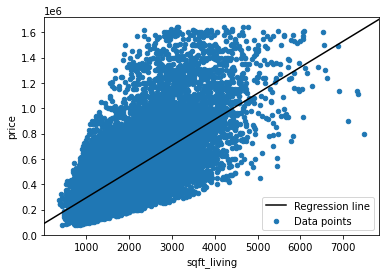

In [14]:
fig, ax = plt.subplots()
df.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax, color="black")
ax.legend();

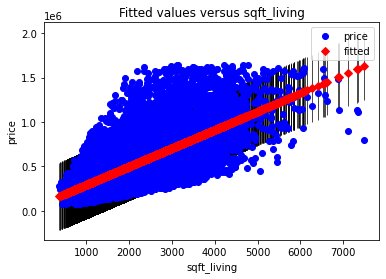

In [15]:
sm.graphics.plot_fit(baseline_results, "sqft_living")
plt.show()

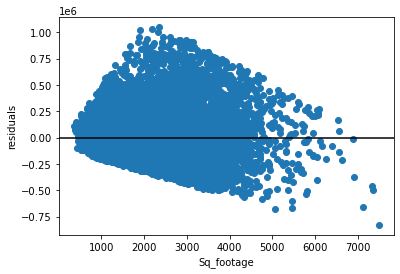

In [16]:
fig, ax = plt.subplots()

ax.scatter(df["sqft_living"], baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("Sq_footage")
ax.set_ylabel("residuals");

In [17]:
#here is our second model where I try and add the 2nd highest correlated value to the model to see if I can bring R2 up
#It appears to not have worked
x_2 = df[['sqft_living', 'bathrooms']]
x_2

second_model = sm.OLS(y, sm.add_constant(x_2))
second_results = second_model.fit()

second_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     8385.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:20:09   Log-Likelihood:            -2.8807e+05
No. Observations:               21191   AIC:                         5.761e+05
Df Residuals:                   21188   BIC:                         5.762e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.415e+04   4061.258     20.721      0.000    7.62e+04    9.21e+04
sqft_living   202.7428      2.350     86.281      0.000     198.137     207.349
bathrooms    5166.4104   2671.349      1.934      0.053     -69.637    1.04e+04
==============================================================================
Omnibus:                     3572.200   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7751.156
Skew:                           0.993   Prob(JB):                         0.00
Kurtosis:                       5.199   Cond. No.                     7.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
#So here is our third model, where we made this after we added our Ordinal and One Hot encoder 
#as well as standized all the numaric values, this performs way better than our first 2 iterations with a R2 of .88
#I think I want to try and improve this with adding our catagorical data ie: grade, condition, and zone

baseline_model2 = sm.OLS(y_train_kch, sm.add_constant(X_train_scaled))
baseline_results2 = baseline_model2.fit()

baseline_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                 2.257e+04
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:20:09   Log-Likelihood:            -2.1557e+05
No. Observations:               16952   AIC:                         4.312e+05
Df Residuals:                   16944   BIC:                         4.312e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.057e+05    619.368    816.486      0.000    5.04e+05    5.07e+05
bedrooms     3342.8305    808.294      4.136      0.000    1758.491    4927.170
bathrooms    1.255e+04   1071.342     11.712      0.000    1.04e+04    1.46e+04
sqft_living  2.047e+05   1000.424    204.620      0.000    2.03e+05    2.07e+05
sqft_lot    -3136.2652    632.827     -4.956      0.000   -4376.673   -1895.858
floors        -19.9933    771.776     -0.026      0.979   -1532.754    1492.768
yr_built    -5293.1293    824.189     -6.422      0.000   -6908.626   -3677.632
price_sqft     1.8e+05    689.156    261.149      0.000    1.79e+05    1.81e+05
==============================================================================
Omnibus:                     3793.018   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39867.977
Skew:                          -0.774   Prob(JB):                         0.00
Kurtosis:                      10.352   Cond. No.                         3.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Evaluate Performance

In [19]:
y_hat= lr.predict(X_train_scaled)
y_hat

array([493072.39525253, 919869.49697746, 232140.27746405, ...,
       227672.84455938, 789521.84383224, 557686.74933203])

In [20]:
resid=(y_train_kch - y_hat)
resid

id
1189000910     23927.604747
1423089055    -74869.496977
6083000050      2859.722536
7390400069    -84399.753924
9468200100   -127307.876261
                  ...      
7806210400    -12285.091006
3211200140     14691.273386
2475200080     40327.155441
7504110030     -4521.843832
952001495      30313.250668
Name: price, Length: 16952, dtype: float64

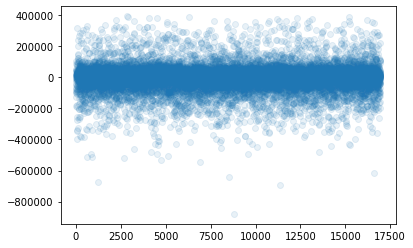

In [21]:
fig, ax  =plt.subplots()
ax.scatter(x=range(y_hat.shape[0]), y=resid, alpha=.1);

In [22]:
pricecorr = df.corr()['price']
pricecorr.abs().sort_values(ascending=False)[1:]

grade_num      0.672391
sqft_living    0.664606
price_sqft     0.505892
bathrooms      0.495658
bedrooms       0.311574
floors         0.277933
sqft_lot       0.091604
yr_built       0.060491
cond_num       0.036234
Name: price, dtype: float64

# Visualizations 

- mean price per square foot in each zone for a average house

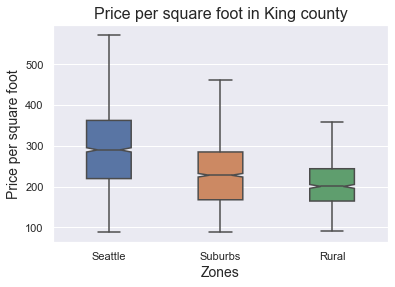

In [23]:
sns.set(style='darkgrid')
boxplot = sns.boxplot(x=test_kch['zones'], y=test_kch['price_sqft'], linewidth=1.5,notch=True,showfliers=False,
                      width =.4, order=['Seattle','Suburbs', 'Rural']);
boxplot.axes.set_title('Price per square foot in King county', fontsize=16)
boxplot.set_xlabel('Zones', fontsize=14)
boxplot.set_ylabel('Price per square foot', fontsize=14)
plt.show()